# Лаба 3
Работаем

libraries + seed прописываем

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

SEED = 501

def set_seed():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.enabled = True

    np.random.seed(SEED)

### Генерим бин. классификкацию, получаем два класса, две фичи, игровую видеокарту.

Text(0, 0.5, 'feature 2')

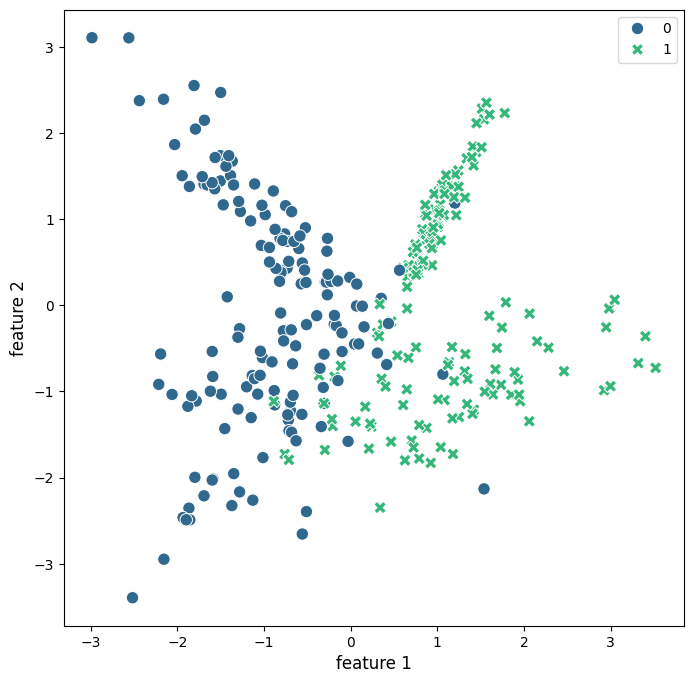

In [37]:
X, y = datasets.make_classification(300, 2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, random_state=SEED)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', style=y, s=80)

plt.xlabel("feature 1", fontsize=12)
plt.ylabel("feature 2", fontsize=12)

### Торч для MLP. 
### Данные при сплите стратифицирую, т.к. их не так много и в таргете неприятные перекосы бывают.

In [11]:
set_seed()

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    
    def forward(self, x):
        return self.model(x).squeeze(-1)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

model = MLP()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

train_losses = []
test_losses = []

epochs = range(1000)
for epoch in epochs:
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss_value = loss(output, y_train_tensor)
    loss_value.backward()
    optimizer.step()
    
    if epoch % 10:
        model.eval()
        train_losses.append(loss_value.item())
        with torch.no_grad():
            test_output = model(X_test_tensor)
            test_loss = loss(test_output, y_test_tensor)
            test_losses.append((test_loss.item()))


    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss_value.item():.4f}, Testloss: {(test_losses[len(test_losses) - 1] if len(test_losses) > 0 else 1):.4f}')

Epoch 0, Loss: 0.6744, Testloss: 1.0000
Epoch 100, Loss: 0.2579, Testloss: 0.2187
Epoch 200, Loss: 0.2125, Testloss: 0.1663
Epoch 300, Loss: 0.2018, Testloss: 0.1510
Epoch 400, Loss: 0.1984, Testloss: 0.1442
Epoch 500, Loss: 0.1972, Testloss: 0.1407
Epoch 600, Loss: 0.1968, Testloss: 0.1388
Epoch 700, Loss: 0.1966, Testloss: 0.1378
Epoch 800, Loss: 0.1965, Testloss: 0.1373
Epoch 900, Loss: 0.1965, Testloss: 0.1370


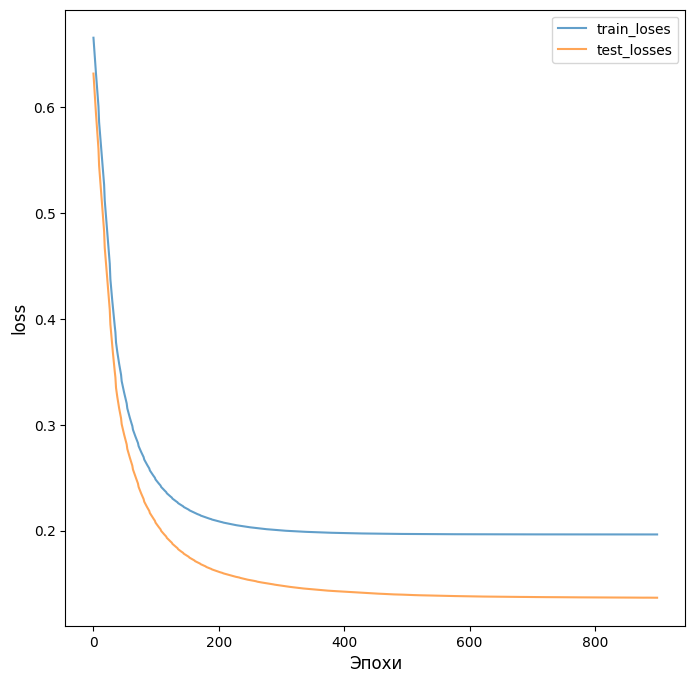

In [40]:
plt.figure(figsize=(8, 8))
plt.plot(train_losses, alpha=0.7, label="train_loses")
plt.plot(test_losses, alpha=0.7, label="test_losses")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

### Какие выводы можно сделать:
1. Тестовые данные показывают лучший лосс, чем тренировочные => тренировочные данные содержат больше выбросов => модель отлично их игнорирует и приближена к истинной зависимости.
2. 1000 эпох - overhead. Начиная с 500 эпохи лосс для теста колебается в районе 0.14.

In [147]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    
    probabilities = torch.sigmoid(logits)
    
    predictions = (probabilities > 0.5).float()
    for i in range(len(X_test_tensor)):
        print(f"Input: {X_test_tensor[i].tolist()}, True: {y_test_tensor[i].item():.2f}, Pred: {predictions[i].item():.2f}")

Input: [-0.30672863125801086, -0.5675033330917358], True: 0.00, Pred: 0.00
Input: [-1.6917486190795898, -2.2109458446502686], True: 0.00, Pred: 0.00
Input: [2.150864839553833, -0.4181044101715088], True: 1.00, Pred: 1.00
Input: [-1.1539438962936401, 0.9790673851966858], True: 0.00, Pred: 0.00
Input: [-1.5634955167770386, 1.7145836353302002], True: 0.00, Pred: 0.00
Input: [1.0111316442489624, 0.9611977338790894], True: 1.00, Pred: 1.00
Input: [-0.7141340970993042, 0.5103417038917542], True: 0.00, Pred: 0.00
Input: [-0.6700685620307922, -0.6798170804977417], True: 0.00, Pred: 0.00
Input: [-1.271741271018982, 1.0884374380111694], True: 0.00, Pred: 0.00
Input: [1.7768399715423584, 2.230475664138794], True: 1.00, Pred: 1.00
Input: [1.3161696195602417, -0.7659726738929749], True: 1.00, Pred: 1.00
Input: [1.0063936710357666, 0.9407654404640198], True: 1.00, Pred: 1.00
Input: [1.9299514293670654, -0.8626502156257629], True: 1.00, Pred: 1.00
Input: [0.77820885181427, 0.3708468973636627], True: 

In [148]:
accuracy = np.mean(predictions.numpy() == y_test)
print(accuracy)

0.9833333333333333


Увидев этот `accurracy` даже мужчина заплачет.